# Modelo ARIMA para forecast

## Importación de librerías

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import os
from google.colab import files
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
data = files.upload()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Saving DatosConsumoCombustibles.csv to DatosConsumoCombustibles.csv


## Extracción de nombre del archivo

In [2]:
file_name=list(data.keys())[0]
file_name

'DatosConsumoCombustibles.csv'

In [ ]:
print(file_name)

DatosConsumoCombustibles.csv


## Lectura de datos

In [3]:
df=pd.read_csv(file_name)
#display(df)
#df=pd.melt(df,id_vars= 'Mes',value_name='Consumo',var_name='Combustible')

df.set_index(pd.date_range(start='2000-01-01', end='2021-06-01',freq='1M',closed='right'),inplace=True)

df.index.name='Fecha'

df.drop(df.index[-4:],axis=0,inplace=True)
df

,Unnamed: 0,Anio,Mes,GasolinaSuper,GasolinaRegular,TotalGasolinas,Diesel,DieselLS,DieselULS,TotalDiesel,GLP,GasolinaAviacion,Kerosina,TurboJet,Bunker,Asfalto,PetCoke,AceitesLubricantes,GrasasLubricantes,Solventes,Naftas,Ceras,CrudoNacional,Butano,Orimulsion,MezclasOleosas,Total
Fecha,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-31,3,2000,1,308156.82,202645.20,510802.02,634667.06,NaN,NaN,634667.06,194410.48,1426.00,64026.09,NaN,296766.99,48446.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1750544.64
2000-02-29,4,2000,2,307766.31,205530.96,513297.27,642380.66,NaN,NaN,642380.66,174710.55,1458.00,62660.30,NaN,328116.44,50597.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1773220.22
2000-03-31,5,2000,3,331910.29,229499.56,561409.85,699807.25,NaN,NaN,699807.25,189234.07,1503.00,61361.99,NaN,368589.63,27593.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1909498.79
2000-04-30,6,2000,4,315648.08,210680.40,526328.48,586803.98,NaN,NaN,586803.98,174330.61,1561.00,61814.32,NaN,396300.47,53794.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1800932.86
2000-05-31,7,2000,5,319667.97,208164.34,527832.31,656948.20,NaN,NaN,656948.20,191745.15,1642.00,54098.32,NaN,449368.92,60137.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1941771.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30,154,2020,9,610445.10,661665.58,1272110.68,NaN,959013.35,9735.38,968748.73,439581.36,948.80,287.45,20238.47,123261.01,26005.63,158485.71,21879.53,509.00,11629.83,35.69,NaN,95762.0,54.92,NaN,356.40,3139895.21
2020-10-31,164,2020,10,648582.82,680362.07,1328944.89,NaN,1064005.30,16475.25,1080480.55,459312.45,1142.86,266.74,29115.90,117108.19,37876.73,254131.92,22655.15,468.37,12831.92,29.42,NaN,128310.0,68.10,NaN,NaN,3472743.19
2020-11-30,174,2020,11,639856.62,652630.16,1292486.78,NaN,1072873.46,10704.69,1083578.15,421504.59,1142.86,231.18,33878.65,111855.80,28761.42,209982.62,21903.24,407.14,10883.80,66.48,NaN,91526.0,70.08,NaN,933.81,3309212.60


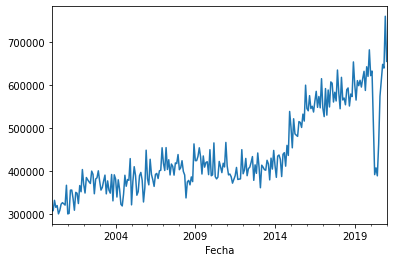

In [5]:
df.GasolinaSuper.plot()
plt.show()

<Figure size 432x288 with 0 Axes>

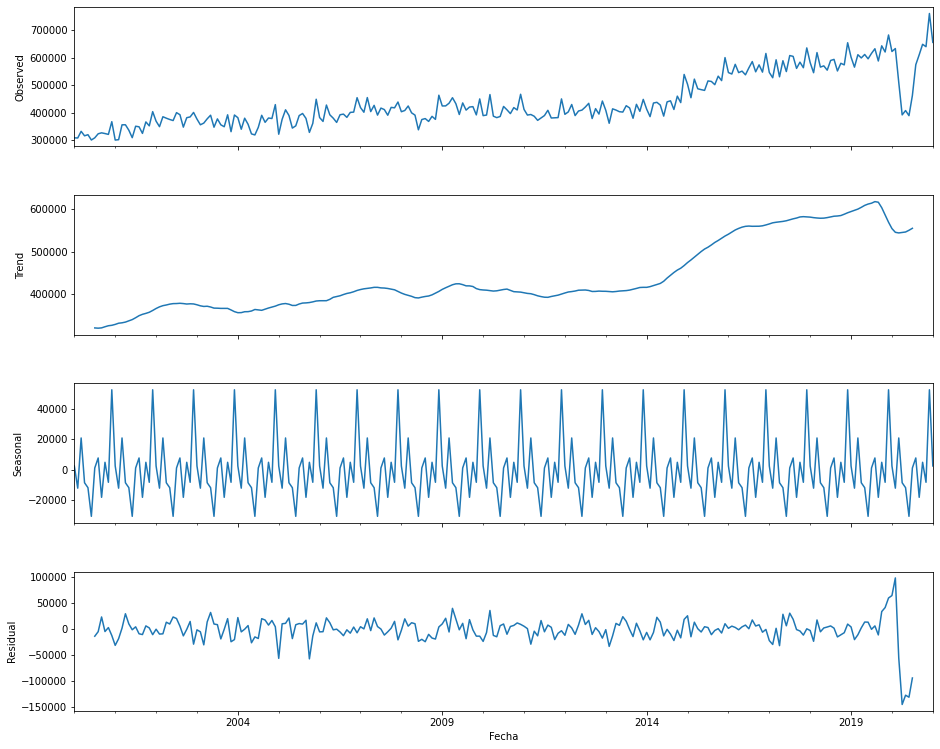

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['GasolinaSuper'], model='additive', freq=12)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)
plt.show()

## Test de Dickey-Fuller

In [7]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(df['GasolinaSuper'])
#to help you, we added the names of every value
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))


{'adf': -0.7612053091027878,
 'criticalvalues': {'1%': -3.4578942529658563,
  '10%': -2.573228767361111,
  '5%': -2.8736593200231484},
 'icbest': 5517.885690038989,
 'nobs': 240,
 'pvalue': 0.8302530248110613,
 'usedlag': 12}

Debido a que el p-value es mayor que 0.05 no podemos rechazar la hipotesis nula

## Primera diferencia para valor d

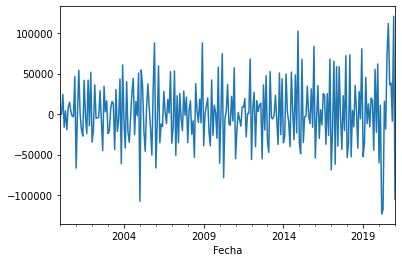

In [8]:
df['1difference']=df['GasolinaSuper']-df['GasolinaSuper'].shift(1)
df['1difference'].plot()
plt.show()

Repetimos el test de Dickey-Fuller

In [9]:
result=adfuller(df['1difference'].dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))


{'adf': -5.799942444431477,
 'criticalvalues': {'1%': -3.4578942529658563,
  '10%': -2.573228767361111,
  '5%': -2.8736593200231484},
 'icbest': 5493.795412974346,
 'nobs': 240,
 'pvalue': 4.656315086449231e-07,
 'usedlag': 11}

Debido a que el p-value es menor que 0.05 se rechaza la hipótesis nula en favor de la alternativa y ya podemos trabajar con el set de datos, el valor de d es 1

## Análisis para valor D

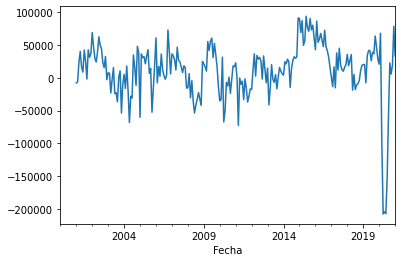

In [10]:
df['Seasonal_Difference']=df['GasolinaSuper']-df['GasolinaSuper'].shift(12)
ax=df['Seasonal_Difference'].plot()
plt.show()

In [11]:
result=adfuller((df['Seasonal_Difference']).dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': -3.0120059173279183,
 'criticalvalues': {'1%': -3.4593607492757554,
  '10%': -2.5735714042782396,
  '5%': -2.8743015807562924},
 'icbest': 5271.60434314921,
 'nobs': 228,
 'pvalue': 0.03378830892398883,
 'usedlag': 12}

Debido a que el p-value es menor que 0.05 se rechaza la hipótesis nula en favor de la alternativa y ya podemos trabajar con el set de datos, el valor de D es 0

## Plots de autocorrelación

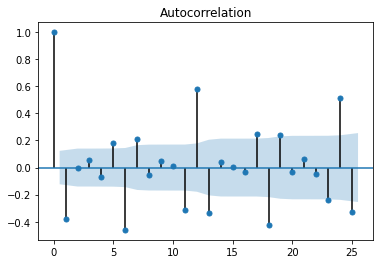

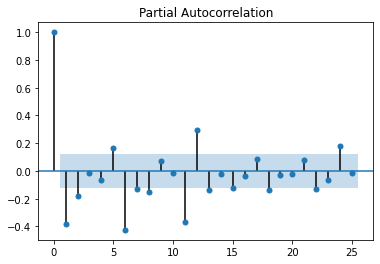

In [12]:
fig1=plot_acf(df['1difference'].dropna())
fig2=plot_pacf(df['1difference'].dropna())
plt.show()

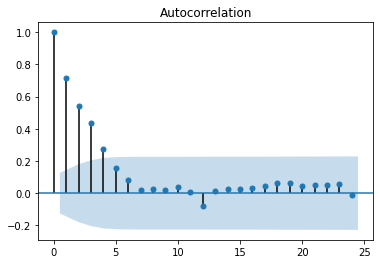

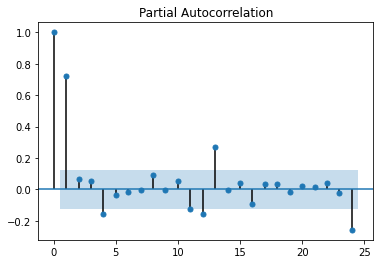

In [13]:
fig1=plot_acf(df['Seasonal_Difference'].dropna())
fig2=plot_pacf(df['Seasonal_Difference'].dropna())
plt.show()

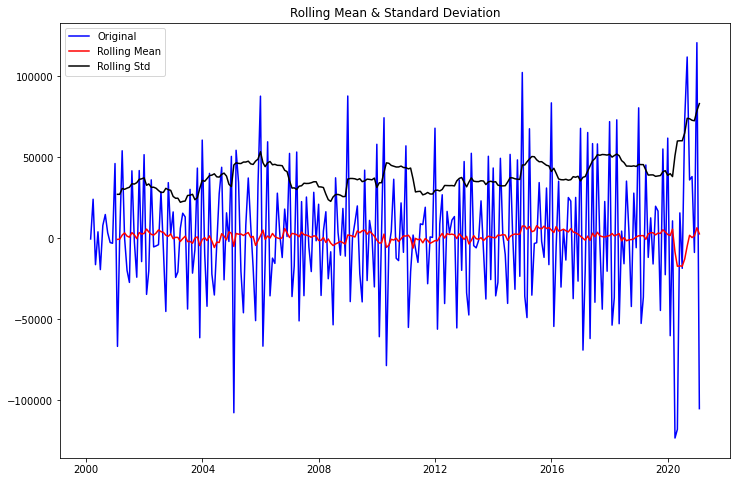

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -5.799942e+00
p-value                        4.656315e-07
#Lags Used                     1.100000e+01
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


In [14]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

test_stationarity(df['1difference'].dropna())

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(df['GasolinaSuper'],order=(6,1,6),seasonal_order=(1, 0, 1, 12))
result=model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


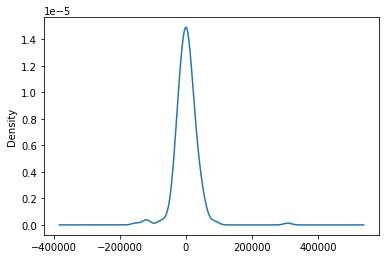

In [21]:
result.resid.plot(kind='kde')


In [22]:
from pandas.tseries.offsets import DateOffset
new_dates=[df.index[-1]+DateOffset(months=x) for x in range(1,18)]
df_pred=pd.DataFrame(index=new_dates,columns =df.columns)
df_pred.head(20)

,Unnamed: 0,Anio,Mes,GasolinaSuper,GasolinaRegular,TotalGasolinas,Diesel,DieselLS,DieselULS,TotalDiesel,GLP,GasolinaAviacion,Kerosina,TurboJet,Bunker,Asfalto,PetCoke,AceitesLubricantes,GrasasLubricantes,Solventes,Naftas,Ceras,CrudoNacional,Butano,Orimulsion,MezclasOleosas,Total,1difference,Seasonal_Difference
2021-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


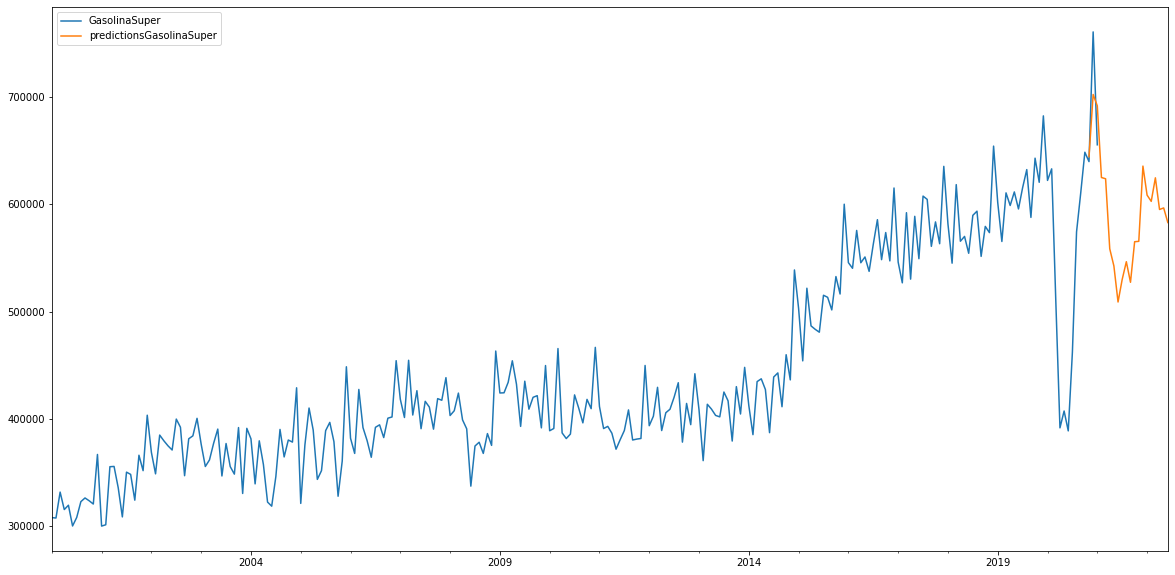

In [23]:
df2=pd.concat([df,df_pred])
df2['predictionsGasolinaSuper']=result.predict(start=250,end=320)
df2[['GasolinaSuper','predictionsGasolinaSuper']].plot(figsize=(20,10))
plt.show()

In [19]:
df2

,Unnamed: 0,Anio,Mes,GasolinaSuper,GasolinaRegular,TotalGasolinas,Diesel,DieselLS,DieselULS,TotalDiesel,GLP,GasolinaAviacion,Kerosina,TurboJet,Bunker,Asfalto,PetCoke,AceitesLubricantes,GrasasLubricantes,Solventes,Naftas,Ceras,CrudoNacional,Butano,Orimulsion,MezclasOleosas,Total,1difference,Seasonal_Difference,predictionsGasolinaSuper
2000-01-31,3,2000,1,308156.82,202645.20,510802.02,634667.06,NaN,NaN,634667.06,194410.48,1426.0,64026.09,NaN,296766.99,48446.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1750544.64,NaN,NaN,NaN
2000-02-29,4,2000,2,307766.31,205530.96,513297.27,642380.66,NaN,NaN,642380.66,174710.55,1458.0,62660.30,NaN,328116.44,50597.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1773220.22,-390.51,NaN,NaN
2000-03-31,5,2000,3,331910.29,229499.56,561409.85,699807.25,NaN,NaN,699807.25,189234.07,1503.0,61361.99,NaN,368589.63,27593.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1909498.79,24143.98,NaN,NaN
2000-04-30,6,2000,4,315648.08,210680.40,526328.48,586803.98,NaN,NaN,586803.98,174330.61,1561.0,61814.32,NaN,396300.47,53794.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1800932.86,-16262.21,NaN,NaN
2000-05-31,7,2000,5,319667.97,208164.34,527832.31,656948.20,NaN,NaN,656948.20,191745.15,1642.0,54098.32,NaN,449368.92,60137.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1941771.90,4019.89,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.188282e+06
2022-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.215358e+06
2022-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.114009e+06
2022-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.053473e+06


In [ ]:
result.forecast(16)

In [ ]:
df2.loc[df2.Index.isna(),'Index']=df2.loc[df2.Index.isna(),'predictions']
df2

In [ ]:
df2.Index.pct_change(periods=12).dropna().tail(20)

In [ ]:
df2.Index.pct_change(periods=12).dropna().plot(figsize=(20,10))